In [1]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import pearsonr
import seaborn as sns
import numpy as np
from env import user,password,host
import os
import acquire
import prepare
#import explore
import env
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
import warnings
warnings.filterwarnings("ignore")

## Acquisition

In [10]:
# Make functions
def check_file_exists(fn, query, url):
    '''
    this function checks to see if the .csv file already exists. If yes it reads it
    '''
    if os.path.isfile(fn):
        print('csv file found and loaded\n')
        return pd.read_csv(fn, index_col=0)
    else: 
        print('creating df and exporting csv\n')
        df = pd.read_sql(query, url)
        df.to_csv(fn)
        return df 
    
def get_zillow_data():
    '''
    This function brings in the Zillow DF using mySQL from the Codeup server
    It uses the env.py file for access
    '''
    url = env.get_db_url('zillow')
    filename = 'zillow.csv'
    query = '''
        select taxvaluedollarcnt, bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, fips,transactiondate
        FROM properties_2017
        JOIN propertylandusetype USING (propertylandusetypeid)
        JOIN predictions_2017 USING (parcelid)
        WHERE propertylandusetypeid IN (261 , 279)
            ;
    '''        
    df = check_file_exists(filename, query, url)
    return df 

In [3]:
#get data
get_zillow_data()

csv file found and loaded



,taxvaluedollarcnt,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,fips,transactiondate
0,1023282.0,4.0,3.5,3100.0,6059.0,2017-01-01
1,464000.0,2.0,1.0,1465.0,6111.0,2017-01-01
2,564778.0,3.0,2.0,1243.0,6059.0,2017-01-01
3,145143.0,4.0,3.0,2376.0,6037.0,2017-01-01
4,773303.0,4.0,3.0,2962.0,6037.0,2017-01-01
...,...,...,...,...,...,...
52437,354621.0,2.0,2.0,1286.0,6037.0,2017-09-20
52438,67205.0,4.0,2.0,1612.0,6111.0,2017-09-21
52439,49546.0,3.0,1.0,1032.0,6037.0,2017-09-21
52440,522000.0,3.0,2.0,1762.0,6037.0,2017-09-25


In [4]:
# make sure the csv is working
get_zillow_data()


csv file found and loaded



,taxvaluedollarcnt,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,fips,transactiondate
0,1023282.0,4.0,3.5,3100.0,6059.0,2017-01-01
1,464000.0,2.0,1.0,1465.0,6111.0,2017-01-01
2,564778.0,3.0,2.0,1243.0,6059.0,2017-01-01
3,145143.0,4.0,3.0,2376.0,6037.0,2017-01-01
4,773303.0,4.0,3.0,2962.0,6037.0,2017-01-01
...,...,...,...,...,...,...
52437,354621.0,2.0,2.0,1286.0,6037.0,2017-09-20
52438,67205.0,4.0,2.0,1612.0,6111.0,2017-09-21
52439,49546.0,3.0,1.0,1032.0,6037.0,2017-09-21
52440,522000.0,3.0,2.0,1762.0,6037.0,2017-09-25


In [2]:
# check import funcions
df = acquire.get_zillow_data()

csv file found and loaded



In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52442 entries, 0 to 52441
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   taxvaluedollarcnt             52441 non-null  float64
 1   bedroomcnt                    52442 non-null  float64
 2   bathroomcnt                   52442 non-null  float64
 3   calculatedfinishedsquarefeet  52360 non-null  float64
 4   fips                          52442 non-null  float64
 5   transactiondate               52442 non-null  object 
dtypes: float64(5), object(1)
memory usage: 2.8+ MB


## Prep

In [7]:
# drop the non 2017
df = df[df['transactiondate'].str.startswith('2017')]



In [8]:
df.transactiondate.max()

'2017-09-25'

In [9]:
def prep_zillow(df):
    '''
    this function cleans up the data. It renames the colums. It makes floats int's, and drops null's.
    Defines the fips as counties
    
    '''
    #rename columns
    df = df.rename(columns = {'bedroomcnt':'bedrooms',
                     'bathroomcnt':'bathrooms',
                     'calculatedfinishedsquarefeet':'area',
                     'taxvaluedollarcnt':'taxvalue',
                     'fips':'county'})
    #dropping nulls
    df = df.dropna()
    # make floats into Int's
    make_ints = ['bedrooms','bathrooms','area','taxvalue']
    for col in make_ints:
        df[col] = df[col].astype(int)
    # define fips as county names    
    df.county = df.county.map({6037:'LA',6059:'Orange',6111:'Ventura'})
    df = df[df['transactiondate'].str.startswith('2017')]
    df = df.drop('transactiondate', axis=1)
    return df

In [9]:
df = prepare.prep_zillow(df)

In [10]:
# check to ensure we didn't drop to many..... 84 is not bad
52442-52358

84

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52358 entries, 0 to 52440
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   taxvalue   52358 non-null  int64 
 1   bedrooms   52358 non-null  int64 
 2   bathrooms  52358 non-null  int64 
 3   area       52358 non-null  int64 
 4   county     52358 non-null  object
dtypes: int64(4), object(1)
memory usage: 2.4+ MB


## Exploration

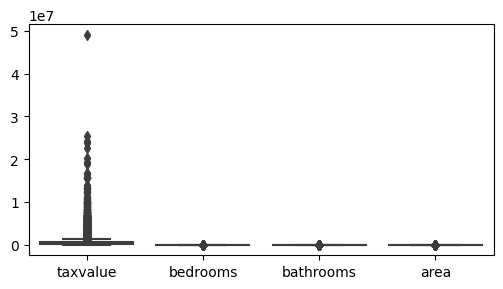

In [25]:
#outliers?
#looking for outliers
plt.figure(figsize=(6, 3))
sns.boxplot(data=df)
plt.show()

In [15]:
# dropping target to see others better 
dfa = df.drop(columns='taxvalue')

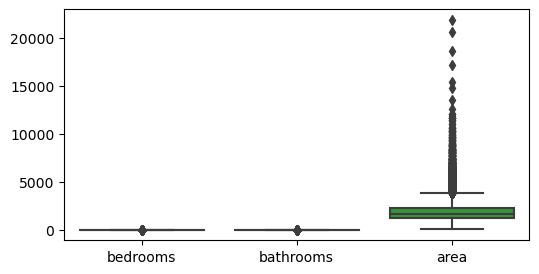

In [18]:
#looking for outliers
plt.figure(figsize=(6, 3))
sns.boxplot(data=dfa)
plt.show()

In [22]:
dfb = df.drop(columns=['area','taxvalue'])

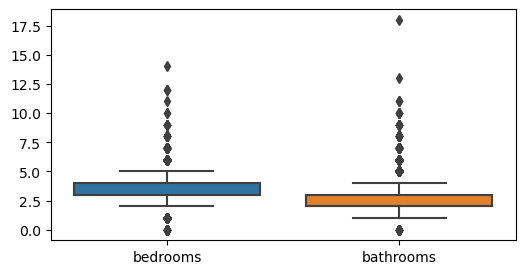

In [23]:
#looking for outliers
plt.figure(figsize=(6, 3))
sns.boxplot(data=dfb)
plt.show()

In [24]:
# there are some outliers in the value, area, bathroom, and bedroom columns

### Im going to find a Z-score for these and drop all with a score greater than 3

In [27]:
# Using Zscore detrmine outliers to remove limit Z score to 3
# Define the z-score threshold for outlier detection
z_threshold = 3
# Calculate the z-scores for each numerical column in the DataFrame
numerical_columns = ['bedrooms', 'bathrooms', 'area', 'taxvalue']
z_scores = np.abs(stats.zscore(df[numerical_columns]))
# Create a boolean mask for outlier detection
outlier_mask = (z_scores > z_threshold).any(axis=1)
# Filter out the rows containing outliers
df_no_outliers = df[~outlier_mask]

In [28]:
#Make sure we dont drop to many rows
#shape before and after outlier removal was 52358
# 1200ish not to bad.... should give a better picture of average to use in a predictive model
# adding this to the prep function
print(df_no_outliers.shape)

(50900, 5)


In [39]:
def prep_zillow(df):
    '''
    This function cleans up the data, renames columns, converts floats to ints, drops nulls, defines fips as counties, and removes outliers.
    '''
    # Rename columns
    df = df.rename(columns={'bedroomcnt': 'bedrooms',
                            'bathroomcnt': 'bathrooms',
                            'calculatedfinishedsquarefeet': 'area',
                            'taxvaluedollarcnt': 'taxvalue',
                            'fips': 'county'})

    # Dropping nulls
    df = df.dropna()

    # Make floats into ints
    make_ints = ['bedrooms', 'bathrooms', 'area', 'taxvalue']
    for col in make_ints:
        df[col] = df[col].astype(int)

    # Define fips as county names
    df['county'] = df['county'].map({6037: 'LA', 6059: 'Orange', 6111: 'Ventura'})

    # Remove outliers
    z_threshold = 3
    numerical_columns = ['bedrooms', 'bathrooms', 'area', 'taxvalue']
    z_scores = np.abs(stats.zscore(df[numerical_columns]))
    outlier_mask = (z_scores < z_threshold).all(axis=1)
    df = df[outlier_mask]

    # Drop the 'transactiondate' column
    df = df.drop('transactiondate', axis=1)

    return df



In [2]:
# functon, function check with dummies
#  import 
df = acquire.get_zillow_data()

csv file found and loaded



In [3]:
df = prepare.prep_zillow(df)


In [4]:
df.head()

,taxvalue,bedrooms,bathrooms,area,lot,county_LA,county_Orange,county_Ventura
0,1023282,4,3,3100,4506,0,1,0
1,464000,2,1,1465,12647,0,0,1
2,564778,3,2,1243,8432,0,1,0
3,145143,4,3,2376,13038,1,0,0
4,773303,4,3,2962,63000,1,0,0


In [5]:
df.describe(include='all')

,taxvalue,bedrooms,bathrooms,area,lot,county_LA,county_Orange,county_Ventura
count,5.045600e+04,50456.000000,50456.000000,50456.000000,50456.000000,50456.000000,50456.000000,50456.000000
mean,4.539024e+05,3.267560,2.157583,1828.633958,8938.304780,0.645235,0.269938,0.084826
std,3.857351e+05,0.880761,0.847716,777.710962,11693.555942,0.478447,0.443932,0.278626
min,1.000000e+03,1.000000,0.000000,152.000000,236.000000,0.000000,0.000000,0.000000
25%,1.888405e+05,3.000000,2.000000,1259.000000,5533.000000,0.000000,0.000000,0.000000
50%,3.640790e+05,3.000000,2.000000,1634.500000,6761.000000,1.000000,0.000000,0.000000
75%,5.900000e+05,4.000000,3.000000,2233.000000,8525.250000,1.000000,1.000000,0.000000
max,2.673077e+06,6.000000,5.000000,4902.000000,270702.000000,1.000000,1.000000,1.000000


In [58]:
# need some dummies for the counties!!
df_dummy=pd.get_dummies(columns=['county'], data=df)
df_dummy.head()
# add to prep file

,taxvalue,bedrooms,bathrooms,area,county_LA,county_Orange,county_Ventura
0,1023282,4,3,3100,0,1,0
1,464000,2,1,1465,0,0,1
2,564778,3,2,1243,0,1,0
3,145143,4,3,2376,1,0,0
4,773303,4,3,2962,1,0,0


In [ ]:
# Br and Bath just became catagoricle
# need another numerical column or this is no longer a regression project
# going to add lotsizesquarefeet and start from the top

In [11]:
def get_zillow_data2():
    '''
    This function brings in the Zillow DF using mySQL from the Codeup server
    It uses the env.py file for access
    '''
    url = env.get_db_url('zillow')
    filename = 'zillow.csv'
    query = '''
        select taxvaluedollarcnt, bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, fips, lotsizesquarefeet, transactiondate
        FROM properties_2017
        JOIN propertylandusetype USING (propertylandusetypeid)
        JOIN predictions_2017 USING (parcelid)
        WHERE propertylandusetypeid IN (261 , 279)
            ;
    '''        
    df = check_file_exists(filename, query, url)
    return df 

In [15]:
df2=get_zillow_data2()

csv file found and loaded



In [5]:
df2.lotsizesquarefeet.describe()


NameError: name 'df2' is not defined

### Ready to split-- prep

In [74]:
# added to prep and rerunning
# check import funcions
df = acquire.get_zillow_data()

csv file found and loaded



In [75]:
df = prepare.prep_zillow(df)


In [76]:
df.describe(include='all')

,taxvalue,bedrooms,bathrooms,area,lot,county_LA,county_Orange,county_Ventura
count,5.045600e+04,50456.000000,50456.000000,50456.000000,50456.000000,50456.000000,50456.000000,50456.000000
mean,4.539024e+05,3.267560,2.157583,1828.633958,8938.304780,0.645235,0.269938,0.084826
std,3.857351e+05,0.880761,0.847716,777.710962,11693.555942,0.478447,0.443932,0.278626
min,1.000000e+03,1.000000,0.000000,152.000000,236.000000,0.000000,0.000000,0.000000
25%,1.888405e+05,3.000000,2.000000,1259.000000,5533.000000,0.000000,0.000000,0.000000
50%,3.640790e+05,3.000000,2.000000,1634.500000,6761.000000,1.000000,0.000000,0.000000
75%,5.900000e+05,4.000000,3.000000,2233.000000,8525.250000,1.000000,1.000000,0.000000
max,2.673077e+06,6.000000,5.000000,4902.000000,270702.000000,1.000000,1.000000,1.000000


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50456 entries, 0 to 52441
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   taxvalue        50456 non-null  int64
 1   bedrooms        50456 non-null  int64
 2   bathrooms       50456 non-null  int64
 3   area            50456 non-null  int64
 4   lot             50456 non-null  int64
 5   county_LA       50456 non-null  uint8
 6   county_Orange   50456 non-null  uint8
 7   county_Ventura  50456 non-null  uint8
dtypes: int64(5), uint8(3)
memory usage: 2.5 MB


In [78]:
train,validate,test = prepare.split_data(df)

train -> (30273, 8), 60.0%
validate -> (10091, 8),20.0%
test -> (10092, 8), 20.0%


In [79]:
train.sample(3)

,taxvalue,bedrooms,bathrooms,area,lot,county_LA,county_Orange,county_Ventura
17473,1967000,3,3,3191,7017,0,1,0
28288,135284,3,2,1242,4880,1,0,0
46078,505077,3,2,1264,4863,1,0,0


### Viz

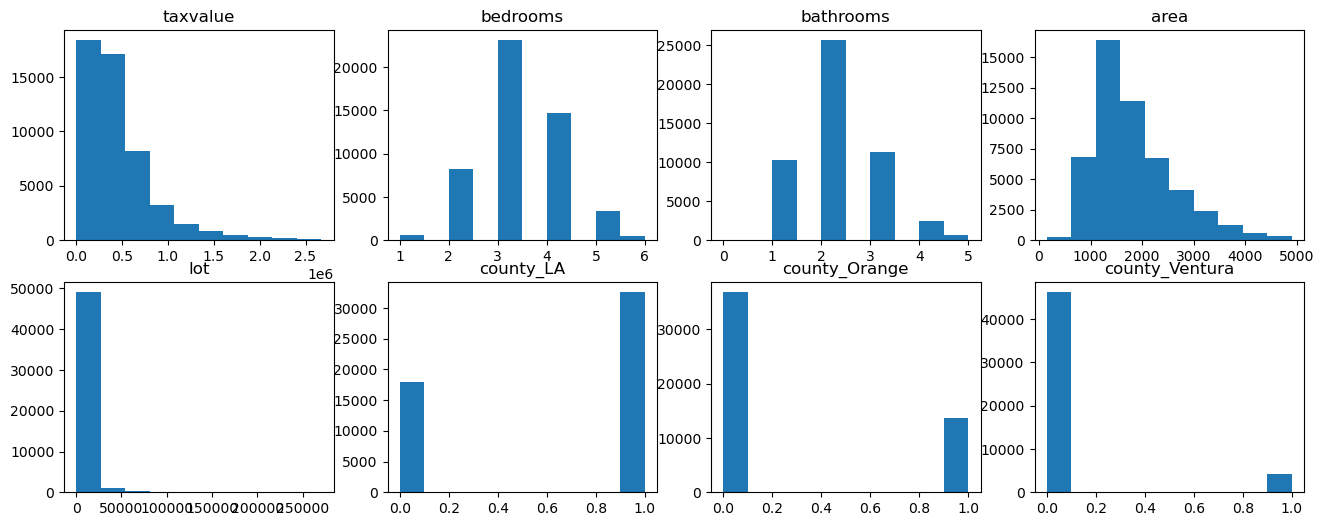

In [21]:

# look at what we have
plt.figure(figsize=(16, 6))

for i, col in enumerate(df.columns):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(2, 4, plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    plt.hist(df[col])

plt.show()

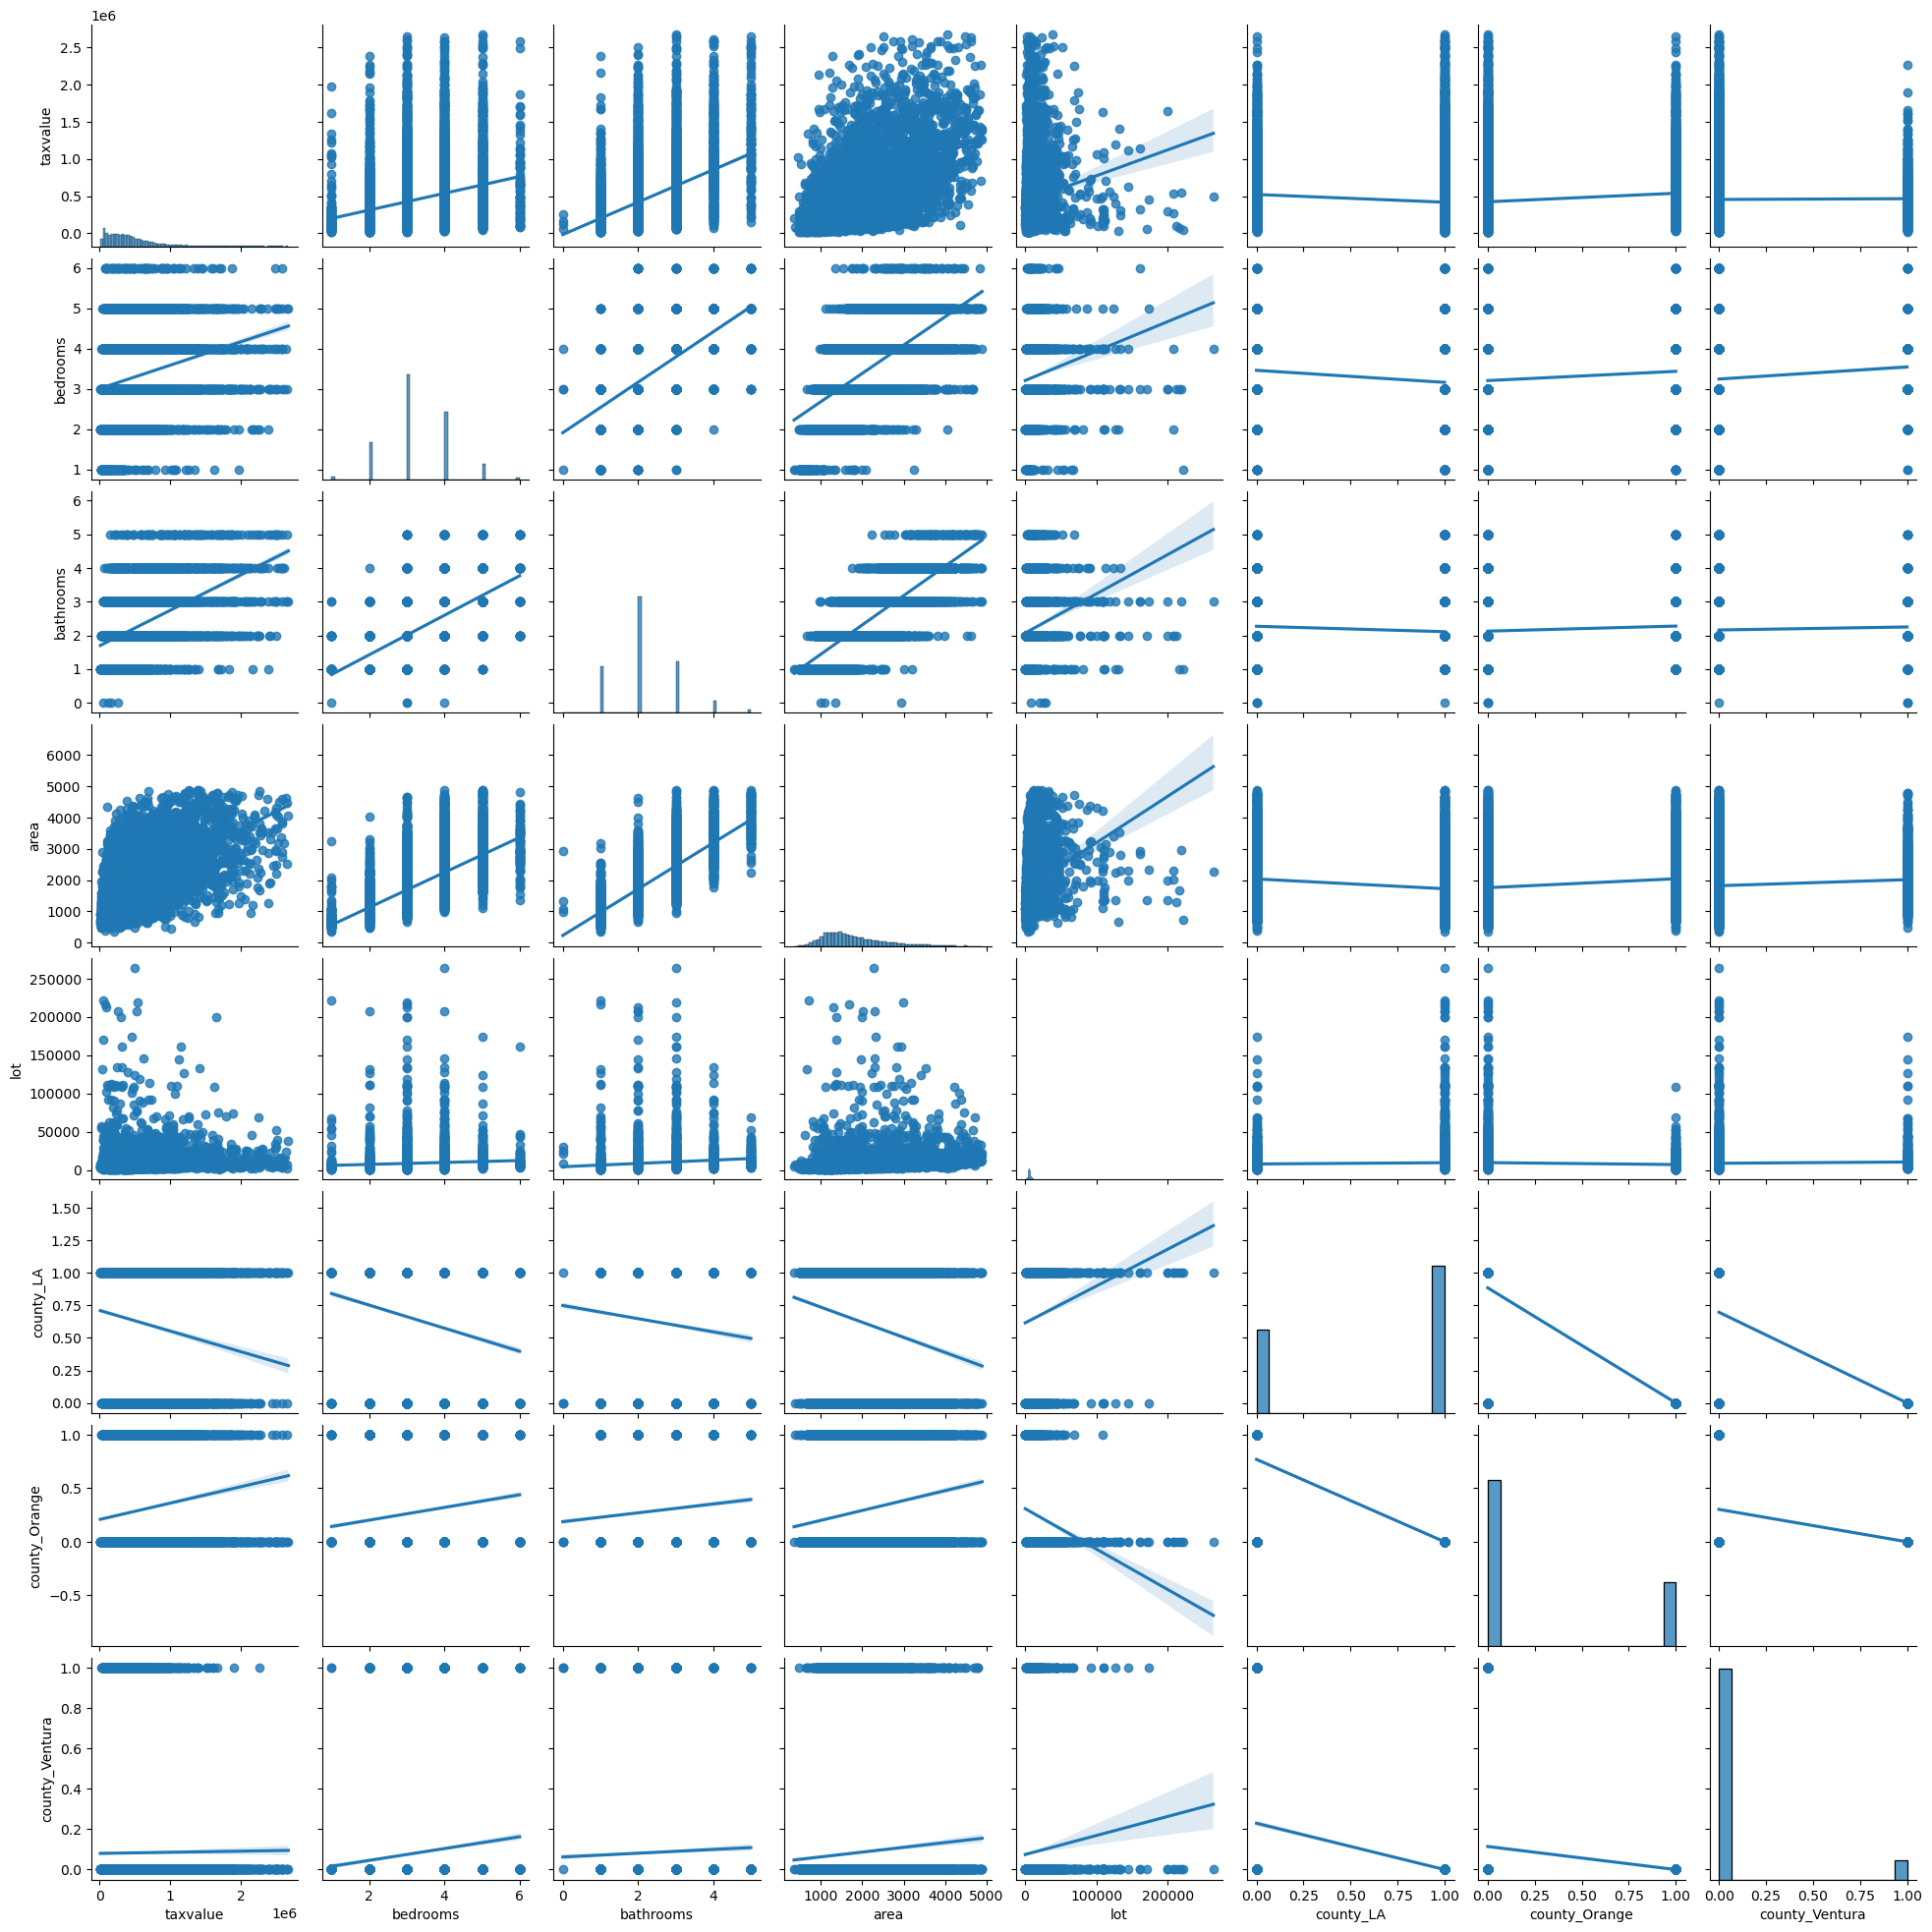

In [22]:
sns.pairplot(test, kind='reg')

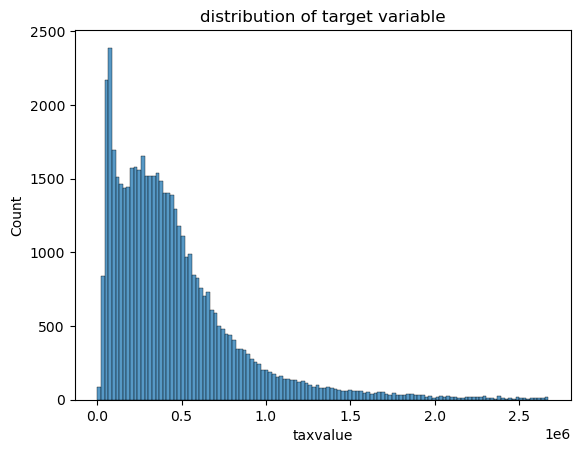

In [13]:
sns.histplot(df.taxvalue)
plt.title('distribution of target variable')
plt.show()

In [24]:
def plot_categorical_and_continuous_vars(df, cat_var, cont_var):
    # plot 1: boxplot
    fig, axs = plt.subplots(figsize=(5,3))
    sns.boxplot(x=cat_var, y=cont_var, data=df)
    axs.set_title(f"{cat_var} vs {cont_var}")
    axs.set_xlabel(cat_var)
    axs.set_ylabel(cont_var)
    plt.show()
    
    # plot 2: violinplot
    fig, axs = plt.subplots(figsize=(5,3))
    sns.violinplot(x=cat_var, y=cont_var, data=df)
    axs.set_title(f"{cat_var} vs {cont_var}")
    axs.set_xlabel(cat_var)
    axs.set_ylabel(cont_var)
    plt.show()
    
    # plot 3: swarmplot
    fig, axs = plt.subplots(figsize=(5,3))
    sns.swarmplot(x=cat_var, y=cont_var, data=df)
    axs.set_title(f"{cat_var} vs {cont_var}")
    axs.set_xlabel(cat_var)
    axs.set_ylabel(cont_var)
    plt.show()


In [29]:
sample = train.sample(n=5000,random_state=123)

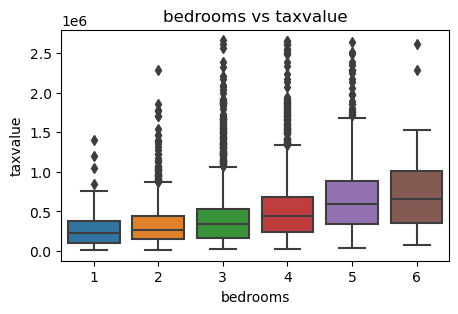

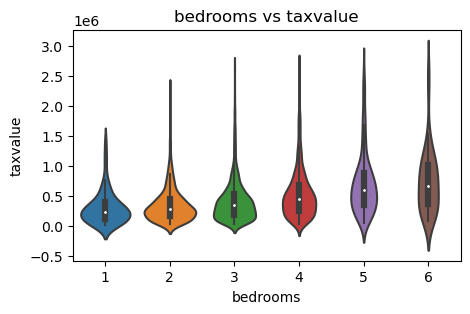

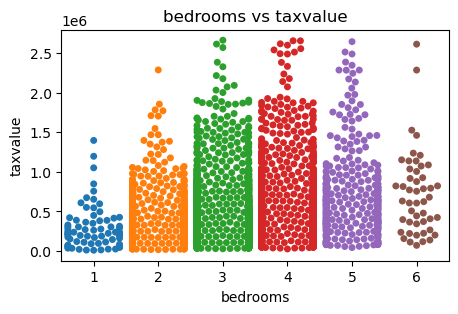

In [30]:
plot_categorical_and_continuous_vars(sample, 'bedrooms', 'taxvalue')

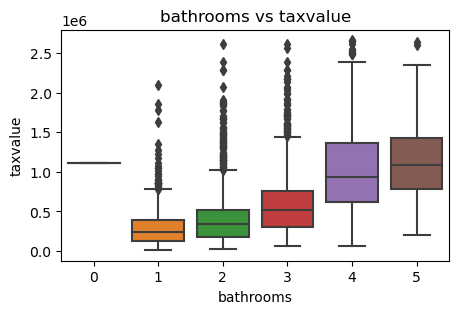

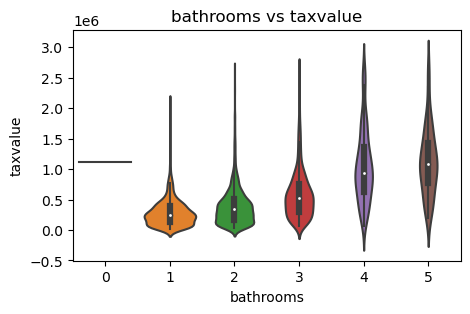

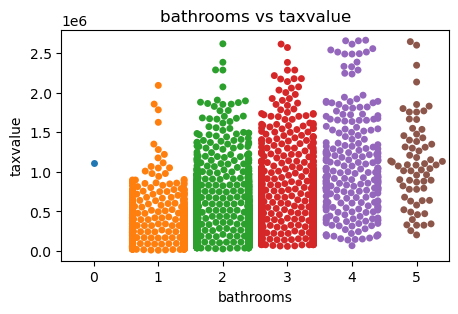

In [31]:
plot_categorical_and_continuous_vars(sample, 'bathrooms', 'taxvalue')

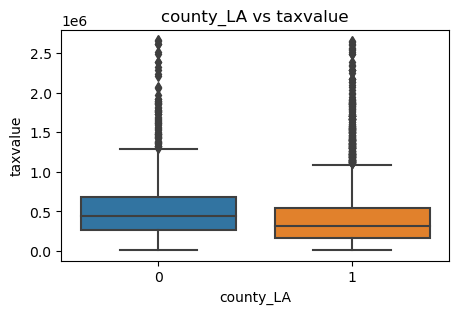

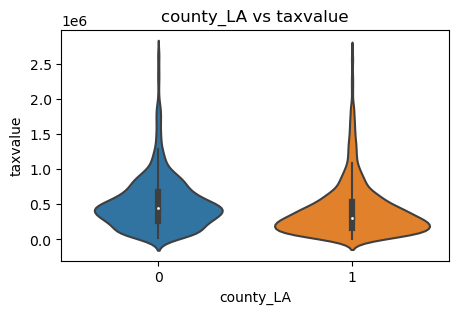

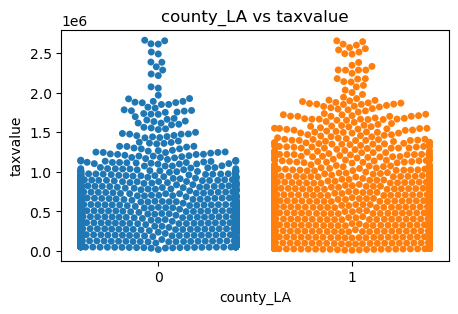

In [32]:
plot_categorical_and_continuous_vars(sample, 'county_LA', 'taxvalue')

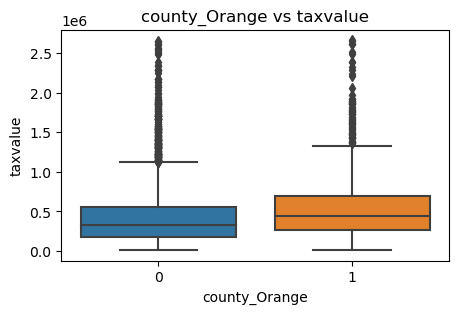

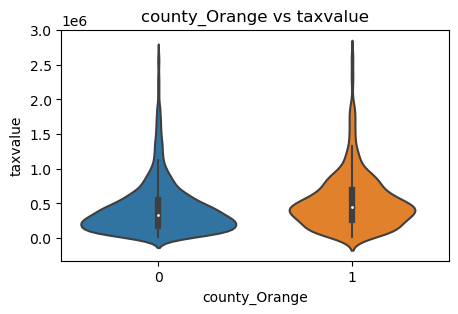

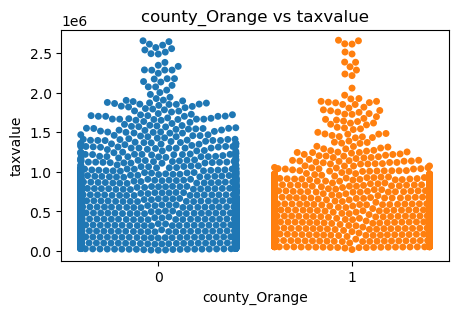

In [33]:
plot_categorical_and_continuous_vars(sample, 'county_Orange', 'taxvalue')

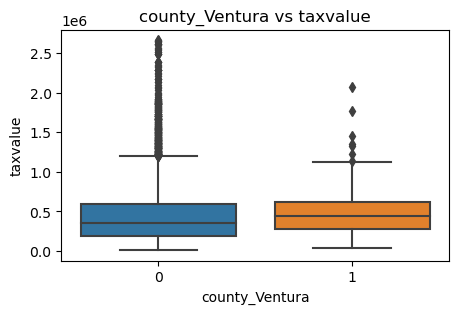

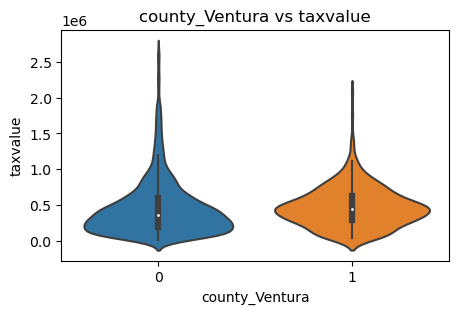

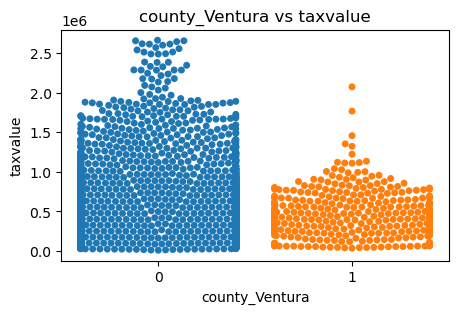

In [34]:
plot_categorical_and_continuous_vars(sample, 'county_Ventura', 'taxvalue')

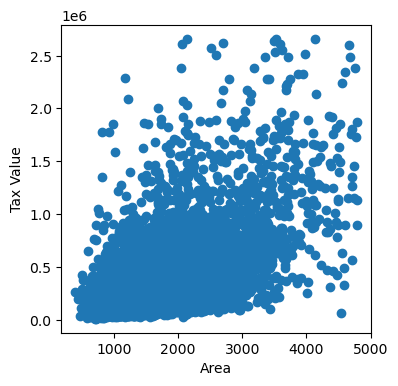

In [38]:
plt.figure(figsize=(4, 4))

plt.scatter(sample.area, sample.taxvalue)
 
plt.xlabel('Area')
plt.ylabel('Tax Value')
plt.show()


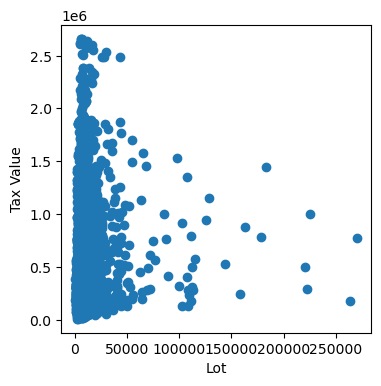

In [39]:
plt.figure(figsize=(4, 4))

plt.scatter(sample.lot, sample.taxvalue)
 
plt.xlabel('Lot')
plt.ylabel('Tax Value')
plt.show()

### Scaling --prep

In [80]:
to_scale = ['area','lot']

In [81]:
def visualize_scaler(scaler, df, columns_to_scale, bins=10):
    #create subplot structure
    fig, axs = plt.subplots(len(columns_to_scale), 2, figsize=(6,6))

    #copy the df for scaling
    df_scaled = df.copy()
    
    #fit and transform the df
    df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

    #plot the pre-scaled data next to the post-scaled data in one row of a subplot
    for (ax1, ax2), col in zip(axs, columns_to_scale):
        ax1.hist(df[col], bins=bins)
        ax1.set(title=f'{col} before scaling', xlabel=col, ylabel='count')
        ax2.hist(df_scaled[col], bins=bins)
        ax2.set(title=f'{col} after scaling with {scaler.__class__.__name__}', xlabel=col, ylabel='count')
    plt.tight_layout()

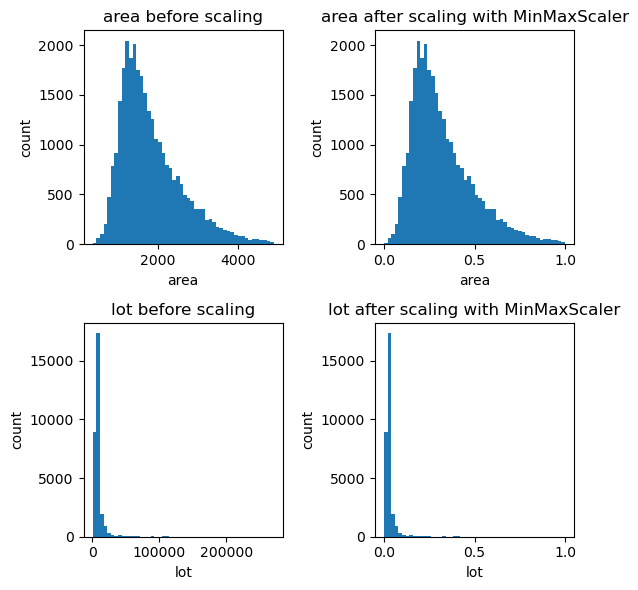

In [65]:
# call function with minmax
visualize_scaler(scaler=MinMaxScaler(), 
                 df=train, 
                 columns_to_scale=to_scale, 
                 bins=50)

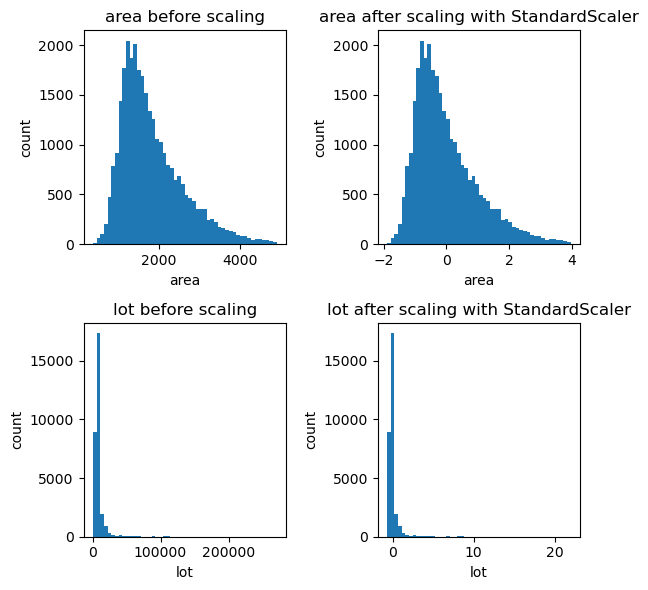

In [49]:
# call function with standard scaler
visualize_scaler(scaler=StandardScaler(), 
                 df=train, 
                 columns_to_scale=to_scale, 
                 bins=50)

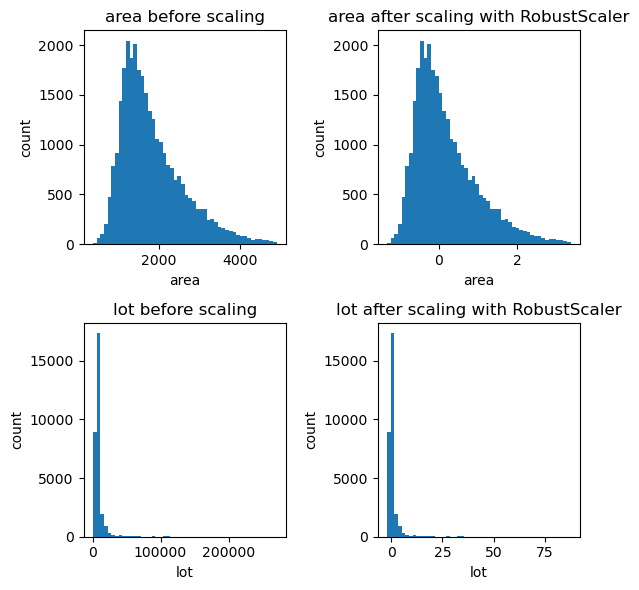

In [82]:
# call function with robustscaler
visualize_scaler(scaler=RobustScaler(), 
                 df=train, 
                 columns_to_scale=to_scale, 
                 bins=50)

In [83]:
#look at original data
train[to_scale].head()

,area,lot
26821,2510,8120
21357,1353,5940
15544,1687,6002
22074,1455,6600
23745,1082,5115


In [84]:
#make it
scaler = MinMaxScaler()

#fit and use it
train_scaled = scaler.fit_transform(train[to_scale])

#convert to df
train_scaled = pd.DataFrame(train_scaled, columns=to_scale)

In [85]:
train_scaled = train_scaled.rename(columns={"area": "area_scaled", "lot": "lot_scaled"})

In [86]:
train_concatenated = pd.concat([train, train_scaled], axis=1)

In [87]:
train_concatenated.head()

,taxvalue,bedrooms,bathrooms,area,lot,county_LA,county_Orange,county_Ventura,area_scaled,lot_scaled
26821,403700.0,5.0,2.0,2510.0,8120.0,0.0,0.0,1.0,0.238441,0.022604
21357,862962.0,3.0,2.0,1353.0,5940.0,0.0,1.0,0.0,0.213562,0.015987
15544,734067.0,3.0,2.0,1687.0,6002.0,1.0,0.0,0.0,0.328049,0.019791
22074,278712.0,4.0,2.0,1455.0,6600.0,0.0,1.0,0.0,0.201673,0.025549
23745,289180.0,3.0,1.0,1082.0,5115.0,1.0,0.0,0.0,0.651035,0.034468


<AxesSubplot:>

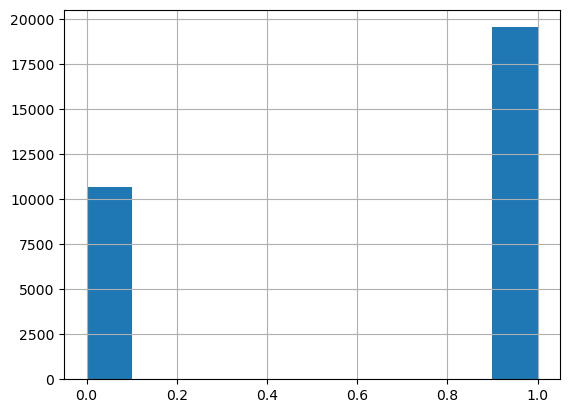

In [94]:
train.county_LA.hist()

<AxesSubplot:>

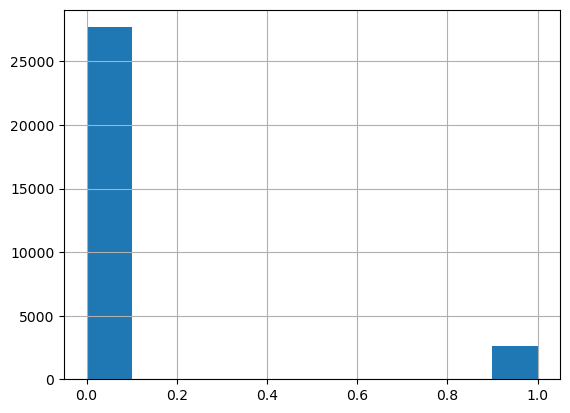

In [93]:
train.county_Ventura.hist()

<AxesSubplot:>

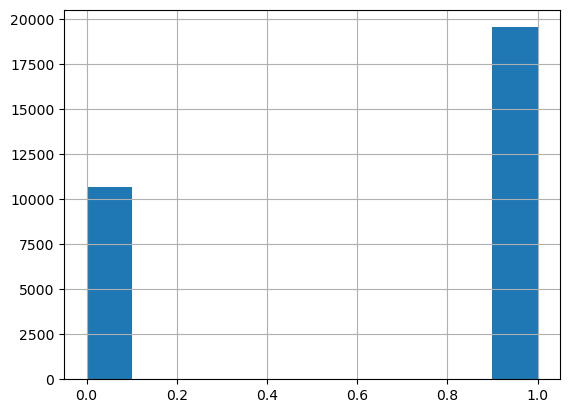

In [92]:
train.county_LA.hist()

<AxesSubplot:>

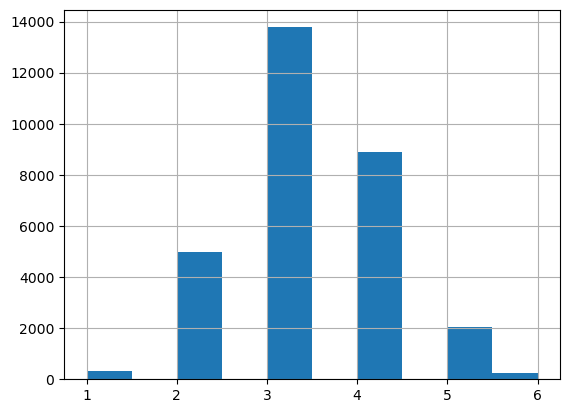

In [89]:
train.bedrooms.hist()

<AxesSubplot:>

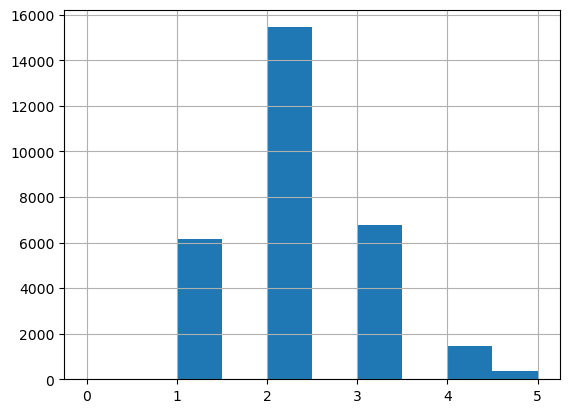

In [91]:
train.bathrooms.hist()

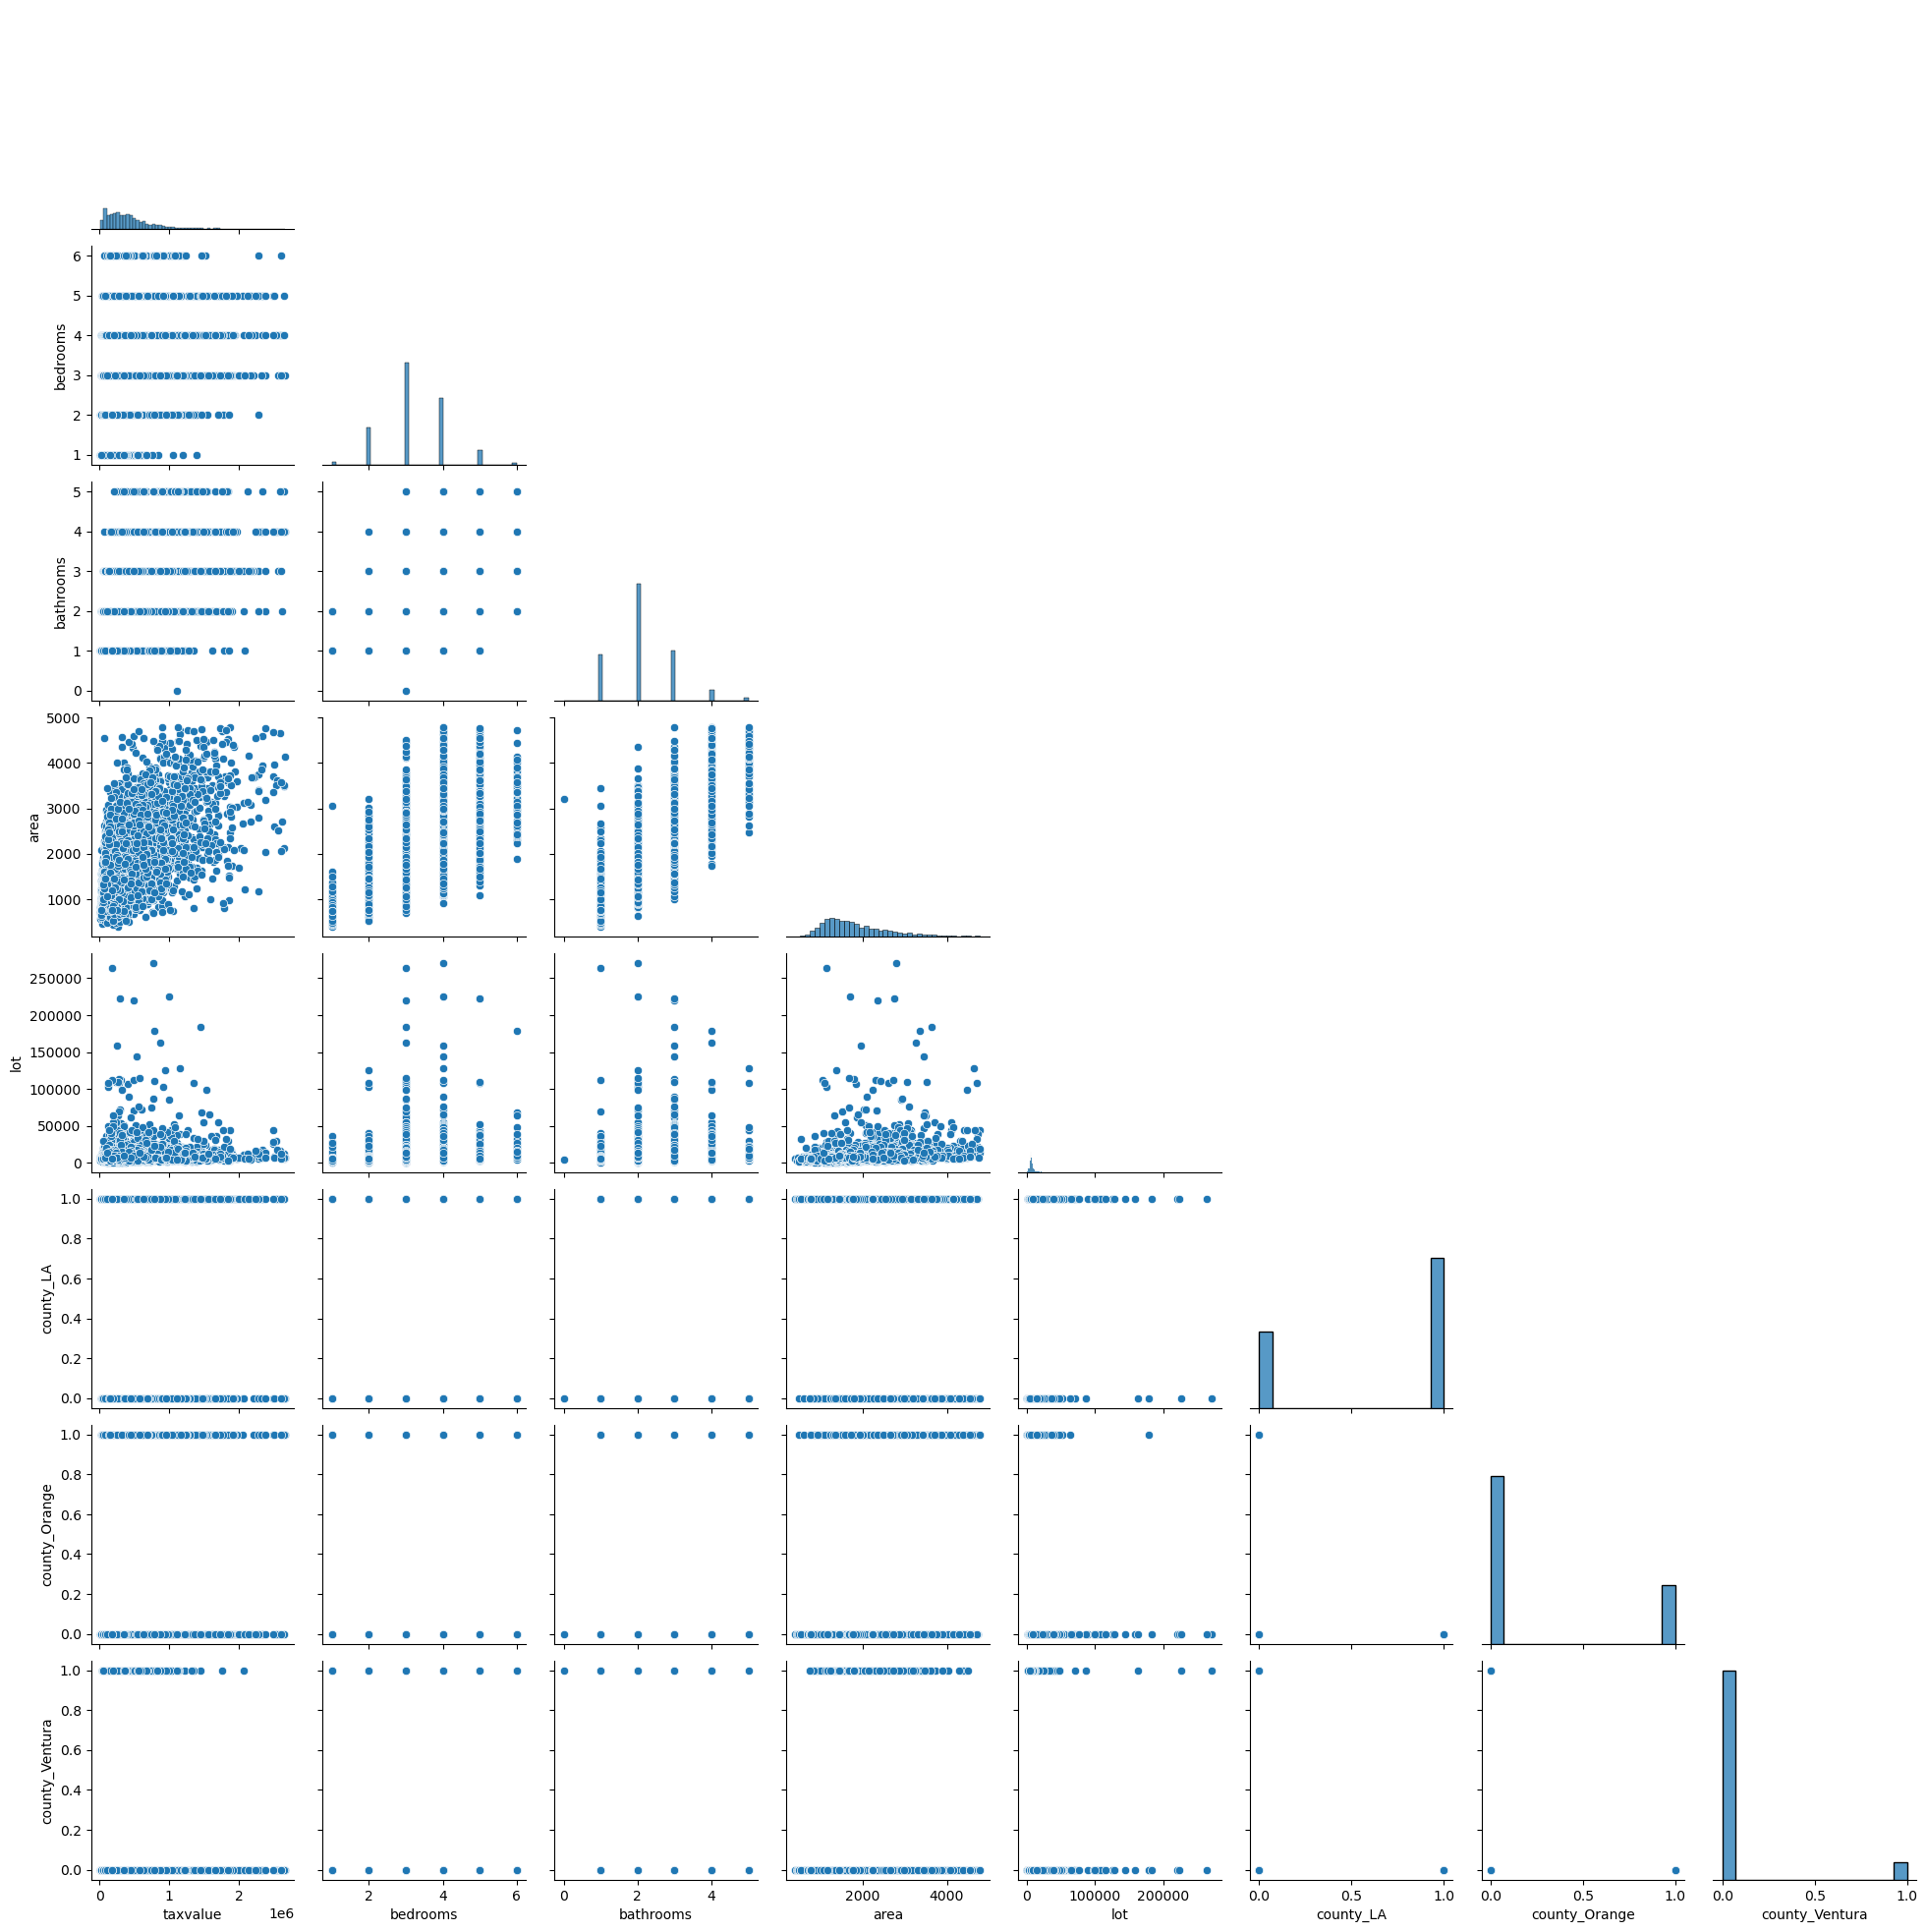

In [95]:
sns.pairplot(sample, corner=True)


aa

In [6]:
df=acquire.get_zillow_data()
df=prepare.prep_zillow(df)
train, validate, test = prepare.split_data(df)

csv file found and loaded

train -> (30273, 9), 60.0%
validate -> (10091, 9),20.0%
test -> (10092, 9), 20.0%


In [7]:
test.head()

,county,taxvalue,bedrooms,bathrooms,area,lot,county_LA,county_Orange,county_Ventura
33774,LA,2400051,3,2,1903,7000,1,0,0
45405,Orange,1054100,1,1,1600,6804,0,1,0
27802,Orange,325813,2,2,1819,14100,0,1,0
22944,Orange,725975,5,2,2246,9984,0,1,0
52114,LA,1264404,3,2,2150,6800,1,0,0


In [27]:
def plot_regression(train):
    sns.color_palette("magma")
    sns.lmplot(x="area", y="taxvalue", hue='county', data=train, scatter=True,scatter_kws={'alpha': 0.2}, line_kws={'linewidth': 3})
    plt.xlabel("Area in Sq.ft")
    plt.ylabel("Tax Value in USD millions")
    plt.show()

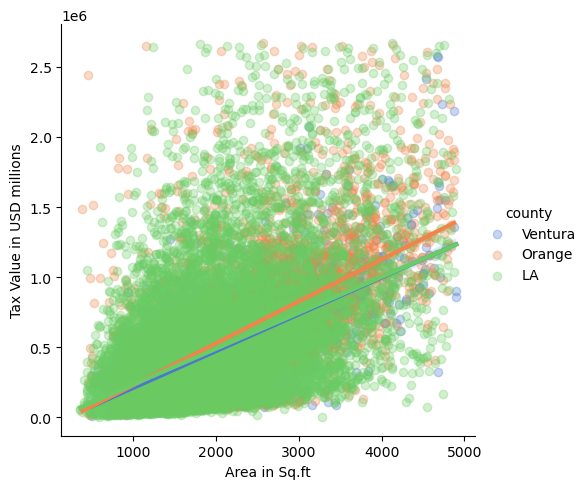

In [28]:
plot_regression(train)

In [30]:
f, p = stats.f_oneway(test.county_LA, test.county_Orange, test.county_Ventura)
f, p


(4766.941420369159, 0.0)

In [97]:
train.columns

Index(['taxvalue', 'bedrooms', 'bathrooms', 'area', 'lot', 'county_LA',
       'county_Orange', 'county_Ventura'],
      dtype='object')

## stats

In [100]:
import pandas as pd
import scipy.stats as stats

def run_t_tests(test, y_var, x_vars):
    results = []
    
    for x_var in x_vars:
        # Perform t-test
        _, p_value = stats.ttest_ind(df[df[x_var] == 0][y_var], df[df[x_var] == 1][y_var])
        results.append({'x_variable': x_var, 'p_value': p_value})
    
    results_df = pd.DataFrame(results)
    return results_df

# Specify the x and y variables
x_vars = [ 'bedrooms', 'bathrooms', 'county_LA', 'county_Ventura', 'county_Orange']
y_var = 'taxvalue'

# Run t-tests
t_test_results = run_t_tests(test, y_var, x_vars)

# Display the results DataFrame
print(t_test_results)
results_df = pd.DataFrame({'Model': 'Logistic Regression','Accuracy': [accuracy], 'Recall': [recall]})
    return results_df

       x_variable        p_value
0        bedrooms            NaN
1       bathrooms   7.420073e-03
2       county_LA  8.093735e-191
3  county_Ventura   1.313272e-05
4   county_Orange  5.639569e-185


In [113]:
import pandas as pd
import scipy.stats as stats

def run_t_tests(test, y_var, x_vars):
    results = []
    
    for x_var in x_vars:
        # Perform t-test
        _, p_value = stats.ttest_ind(test[test[x_var] == 0][y_var], test[test[x_var] == 1][y_var])
        results.append({'x_variable': x_var, 'p_value': p_value})
    
    results_df = pd.DataFrame(results)
    return results_df
 

In [114]:
run_t_tests(test, y_var, x_vars)

,x_variable,p_value
0,bedrooms,NaN
1,bathrooms,2.839604e-01
2,county_LA,2.036365e-38
3,county_Ventura,4.323819e-01
4,county_Orange,4.923013e-41


In [117]:

def run_t_tests(test, y_var, x_vars):
    results = []
    a=0.05
    for x_var in x_vars:
        # Perform t-test
        _, p_value = stats.ttest_ind(test[test[x_var] == 0][y_var], test[test[x_var] == 1][y_var])
        
        # Round p-value to 4 decimal places
        rounded_p_value = round(p_value, 4)
        
        # Evaluate p-value compared to alpha
        if rounded_p_value < a:
            evaluation = "Reject Null"
        else:
            evaluation = "Fail to Reject"
            
        results.append({'x_variable': x_var, 'p_value': rounded_p_value, 'evaluation': evaluation})
    
    results_df = pd.DataFrame(results)
    return results_df



In [118]:
run_t_tests(test, y_var, x_vars)

,x_variable,p_value,evaluation
0,bedrooms,NaN,Fail to Reject
1,bathrooms,0.2840,Fail to Reject
2,county_LA,0.0000,Reject Null
3,county_Ventura,0.4324,Fail to Reject
4,county_Orange,0.0000,Reject Null


##### Hypothisis for bedrooms
$H_0$ : The number bedrooms does not have a linear relationship to tax value<br>
$H_a$ : The number bedrooms does  have a linear relationship to tax value

In [143]:
def get_brstats(data):
    x_var = 'bedrooms'
    y_var = 'taxvalue'
    alpha=0.05
    # Perform Pearson correlation test
    r, p_value = stats.pearsonr(data[x_var], data[y_var])
    # Round p-value to 4 decimal places
    rounded_p_value = round(p_value, 6)
    # Evaluate p-value compared to alpha
    if rounded_p_value < alpha:
        evaluation = "Reject Null"
    else:
        evaluation = "Fail to Reject"
    results = {'x_variable': x_var, 'r': r, 'p_value': rounded_p_value, 'evaluation': evaluation}
    results_df = pd.DataFrame(results, index=[0])
    return results_df

In [144]:
get_brstats(test)

,x_variable,r,p_value,evaluation
0,bedrooms,0.256363,0.0,Reject Null


In [67]:
def run_bathttest(data):
    x = data['bathrooms']
    y = data['taxvalue']
    # Perform t-test
    t_statistic, p_value = stats.ttest_ind(x, y)
    # Decide whether to reject the null hypothesis
    alpha = 0.05
    if p_value < alpha:
        decision = "Reject Null Hypothesis"
    else:
        decision = "Fail to Reject Null Hypothesis"
# Create a DataFrame to store the results
    results = pd.DataFrame({
        'T-Statistic': [t_statistic],
        'P-Value': [p_value],
        'Decision': [decision]
    })
    
    return results

In [68]:
# Call the function with the 'train' DataFrame
run_bathttest(train)


,T-Statistic,P-Value,Decision
0,-205.166626,0.0,Reject Null Hypothesis


In [74]:
def run_lattest(data):
    x = data['county_LA']
    y = data['taxvalue']
    # Perform t-test
    t_statistic, p_value = stats.ttest_ind(x, y)
    # Decide whether to reject the null hypothesis
    alpha = 0.05
    if p_value < alpha:
        decision = "Reject Null Hypothesis"
    else:
        decision = "Fail to Reject Null Hypothesis"
# Create a DataFrame to store the results
    results = pd.DataFrame({
        'T-Statistic': [t_statistic],
        'P-Value': [p_value],
        'Decision': [decision]
    })
    
    return results

In [75]:
run_lattest(train)

,T-Statistic,P-Value,Decision
0,-205.16731,0.0,Reject Null Hypothesis


In [76]:
def run_ventttest(data):
    x = data['county_Ventura']
    y = data['taxvalue']
    # Perform t-test
    t_statistic, p_value = stats.ttest_ind(x, y)
    # Decide whether to reject the null hypothesis
    alpha = 0.05
    if p_value < alpha:
        decision = "Reject Null Hypothesis"
    else:
        decision = "Fail to Reject Null Hypothesis"
# Create a DataFrame to store the results
    results = pd.DataFrame({
        'T-Statistic': [t_statistic],
        'P-Value': [p_value],
        'Decision': [decision]
    })
    
    return results

In [78]:
run_ventttest(train)

,T-Statistic,P-Value,Decision
0,-205.167564,0.0,Reject Null Hypothesis


In [82]:
def run_bathttest(data):
    x = data['bathrooms']
    y = data['taxvalue']
    # Perform t-test
    t_statistic, p_value = stats.ttest_ind(x, y)
    # Decide whether to reject the null hypothesis
    alpha = 0.05
    if p_value < alpha:
        decision = "Reject Null Hypothesis"
    else:
        decision = "Fail to Reject Null Hypothesis"
# Create a DataFrame to store the results
    results = pd.DataFrame({
        'T-Statistic': [t_statistic],
        'P-Value': [p_value],
        'Decision': [decision]
    })
    
    return results

In [83]:
run_bathttest(train)

,T-Statistic,P-Value,Decision
0,-205.166626,0.0,Reject Null Hypothesis


In [84]:
def run_orangettest(data):
    x = data['county_Orange']
    y = data['taxvalue']
    # Perform t-test
    t_statistic, p_value = stats.ttest_ind(x, y)
    # Decide whether to reject the null hypothesis
    alpha = 0.05
    if p_value < alpha:
        decision = "Reject Null Hypothesis"
    else:
        decision = "Fail to Reject Null Hypothesis"
# Create a DataFrame to store the results
    results = pd.DataFrame({
        'T-Statistic': [t_statistic],
        'P-Value': [p_value],
        'Decision': [decision]
    })
    
    return results

In [86]:
run_orangettest(train)

,T-Statistic,P-Value,Decision
0,-205.167482,0.0,Reject Null Hypothesis


In [87]:
train.columns

Index(['county', 'taxvalue', 'bedrooms', 'bathrooms', 'area', 'lot',
       'county_LA', 'county_Orange', 'county_Ventura'],
      dtype='object')